In [1]:
import pandas as pd
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pmdarima as pm
import itertools

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from pmdarima.arima import auto_arima
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.stattools import acf, pacf
from datetime import datetime
from scipy import stats
from scipy.stats import boxcox
import statsmodels.tsa as smt


import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

<AxesSubplot:xlabel='DATE'>

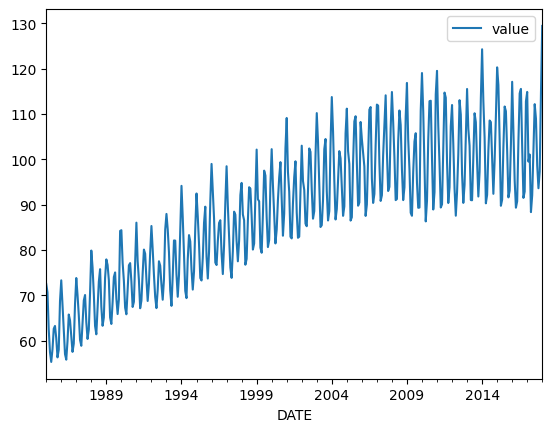

In [2]:
df = pd.read_csv('Electric_Production.csv')
df
df['DATE'] = pd.to_datetime(df['DATE']) # To convert dtype column 'DATE'
df = df.set_index('DATE')
df.rename(columns={'IPG2211A2N':'value'}, inplace=True) # To convert column name
df.plot()

In [34]:
def tsplot(y, lags=None, figsize=(15, 10), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title('Time Series Analysis Plots')
        plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

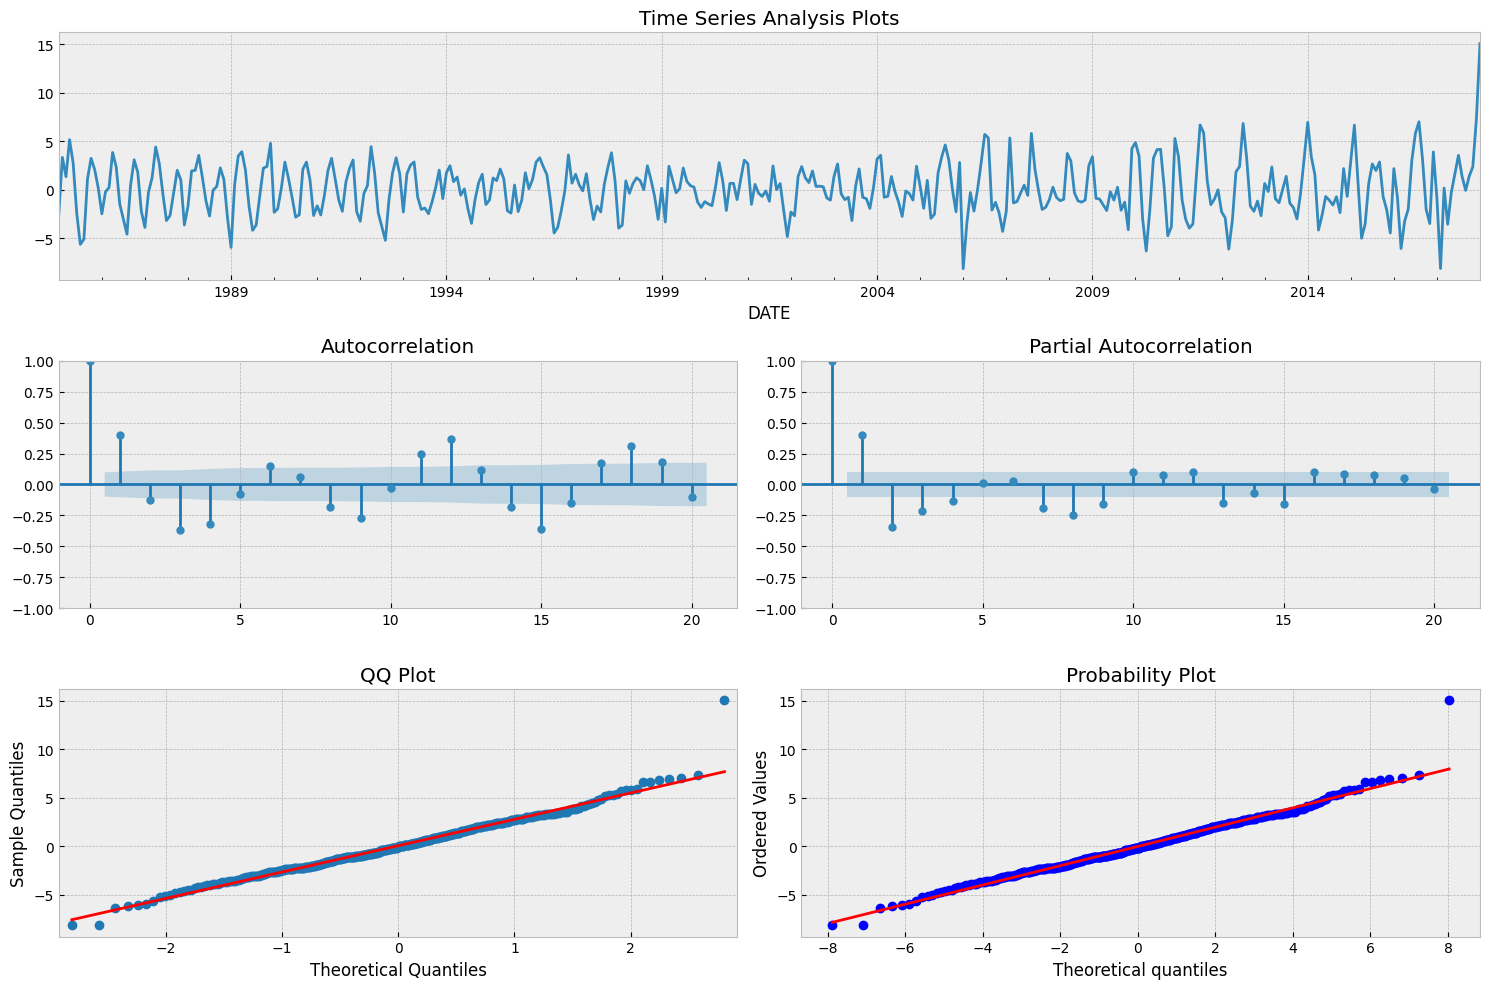

In [35]:
decomposition= sm.tsa.seasonal_decompose(df['value'], model='additive', extrapolate_trend="freq")
tsplot(decomposition.resid, lags=20)

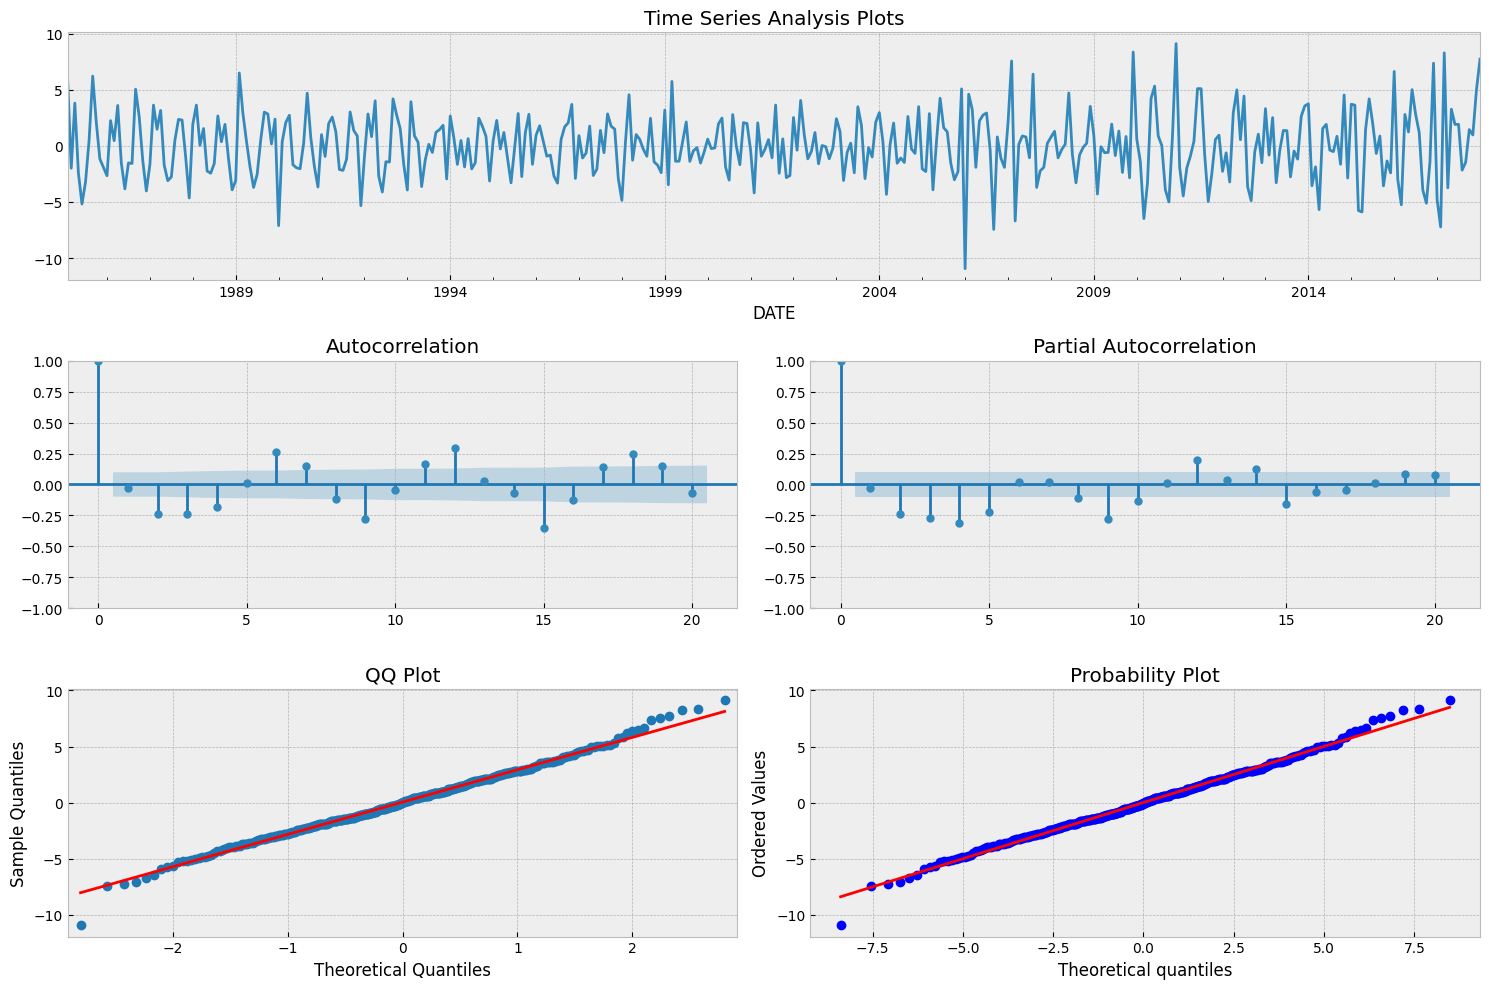

In [37]:
#1st diffrence

diff_df = decomposition.resid.diff(periods=1).iloc[1:]
tsplot(diff_df, 20)

In [22]:
# ADF test

adf_test = adfuller(diff_df)

print('ADF Statistic: %f' % adf_test[0])
print('Critical Values @ 0.05: %.2f' % adf_test[4]['5%'])
print('p-value: %20.20f' % adf_test[1])

ADF Statistic: -10.799906
Critical Values @ 0.05: -2.87
p-value: 0.00000000000000000020


In [39]:
# The combination is for ARIMA order.

model = pm.auto_arima(diff_df, d=1,
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=2240.315, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=2175.928, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.37 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=2238.315, Time=0.05 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=2139.318, Time=0.18 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=2112.074, Time=0.24 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=2068.051, Time=0.26 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1988.556, Time=0.32 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.95 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1986.593, Time=0.16 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=2066.066, Time=0.11 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=1.31 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.62 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit t

In [42]:
# create model
model = sm.tsa.arima.ARIMA(diff_df, order= (5,1,0))
results = model.fit()

print(results.summary())

                               SARIMAX Results                                
Dep. Variable:                  resid   No. Observations:                  396
Model:                 ARIMA(5, 1, 0)   Log Likelihood                -987.297
Date:                Wed, 09 Nov 2022   AIC                           1986.593
Time:                        17:48:53   BIC                           2010.467
Sample:                    02-01-1985   HQIC                          1996.052
                         - 01-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.8438      0.040    -20.900      0.000      -0.923      -0.765
ar.L2         -0.8126      0.053    -15.203      0.000      -0.917      -0.708
ar.L3         -0.7423      0.059    -12.618      0.0

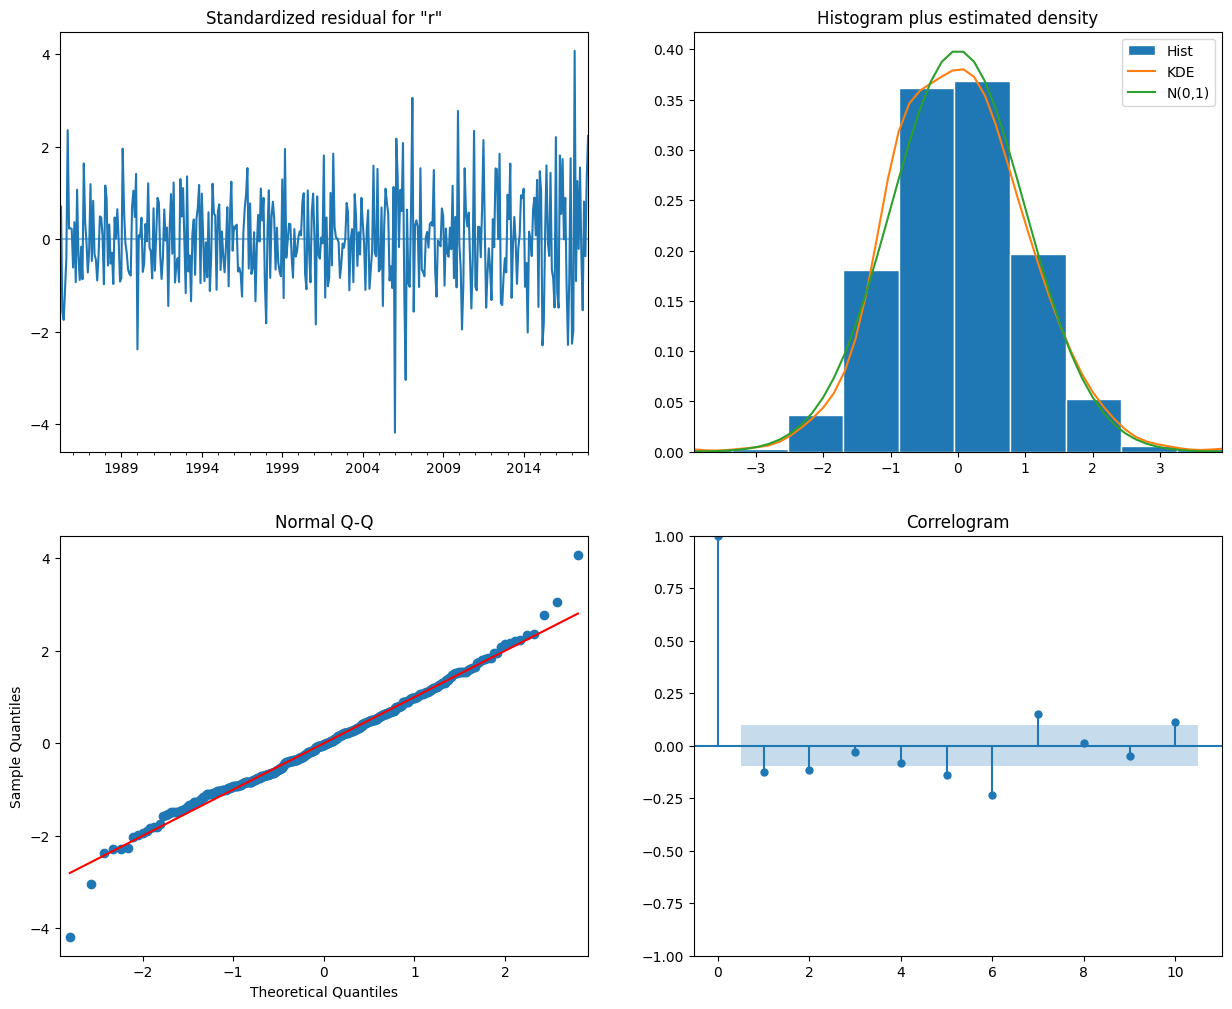

In [43]:
results.plot_diagnostics(figsize=(15,12))
plt.show()

Performing stepwise search to minimize aic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1752.160, Time=0.04 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=1701.158, Time=0.10 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.25 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1750.166, Time=0.03 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=1674.249, Time=0.10 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=1650.182, Time=0.27 sec
 ARIMA(4,1,0)(0,0,0)[0] intercept   : AIC=1609.067, Time=0.22 sec
 ARIMA(5,1,0)(0,0,0)[0] intercept   : AIC=1533.857, Time=0.26 sec
 ARIMA(5,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=1.32 sec
 ARIMA(4,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.89 sec
 ARIMA(5,1,0)(0,0,0)[0]             : AIC=1531.860, Time=0.22 sec
 ARIMA(4,1,0)(0,0,0)[0]             : AIC=1607.089, Time=0.13 sec
 ARIMA(5,1,1)(0,0,0)[0]             : AIC=inf, Time=1.03 sec
 ARIMA(4,1,1)(0,0,0)[0]             : AIC=inf, Time=0.68 sec

Best model:  ARIMA(5,1,0)(0,0,0)[0]          
Total fit t

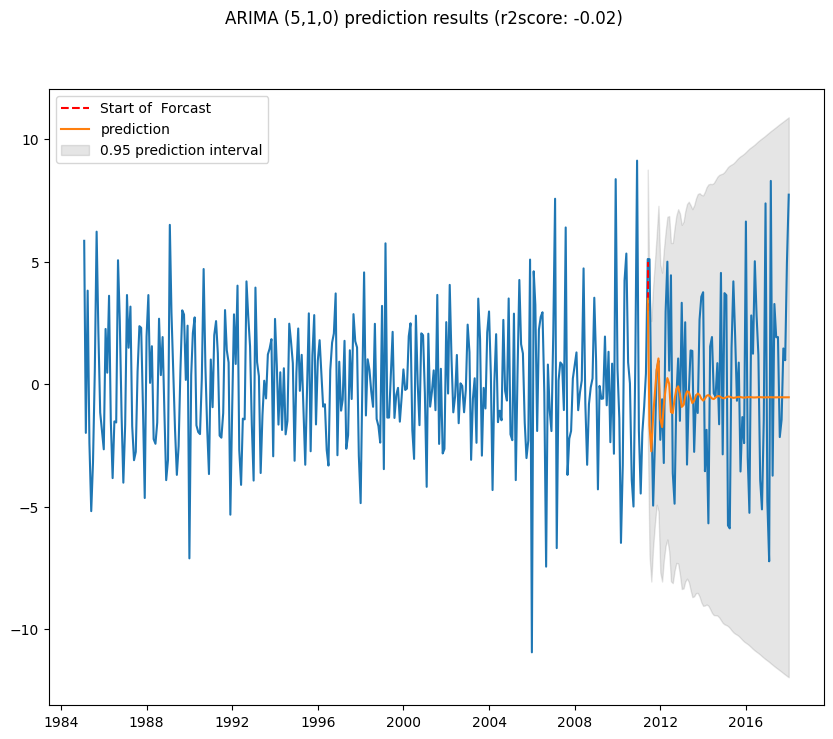

In [48]:
train_set, test_set = train_test_split(diff_df, test_size = 0.2, shuffle=False)
# Search parameters for train set
model = pm.auto_arima(train_set, d=1, seasonal=True, #consider seasonality
                      start_p=0, start_q=0, max_order=6, test='adf',
                      stepwise=True, trace=True)
model = sm.tsa.arima.ARIMA(train_set, order= (5,1,0))
results = model.fit()
y_pred = results.get_forecast(len(test_set))
pred = y_pred
pred_value = pred.predicted_mean

#upper bound
pred_ub = pred.conf_int().iloc[:,0]

#lower bound
pred_lb = pred.conf_int().iloc[:,1]
pred_index = list(test_set.index)
r2 = r2_score(test_set, pred_value)
fig, ax= plt.subplots(figsize=(10,8))
ax.plot(diff_df.index, diff_df)
ax.vlines(pd.to_datetime('2011-06-01'), 3,5, linestyle ='--', color='r',
         label = 'Start of  Forcast')
ax.plot(pred_index, pred_value, label='prediction')
ax.fill_between(pred_index, pred_lb, pred_ub, color='k',
               alpha= 0.1, label='0.95 prediction interval')
ax.legend(loc='upper left')
plt.suptitle(f'ARIMA (5,1,0) prediction results (r2score: {round(r2,2)})')
plt.show()